In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect


class ImageTransformer:
    """Transform features to an image matrix using dimensionality reduction
    This class takes in data normalized between 0 and 1 and converts it to a
    CNN compatible 'image' matrix
    """

    def __init__(self, feature_extractor='tsne', pixels=100,
                 random_state=None, n_jobs=None):
        """Generate an ImageTransformer instance
        Args:
            feature_extractor: string of value ('tsne', 'pca', 'kpca') or a
                class instance with method `fit_transform` that returns a
                2-dimensional array of extracted features.
            pixels: int (square matrix) or tuple of ints (height, width) that
                defines the size of the image matrix.
            random_state: int or RandomState. Determines the random number
                generator, if present, of a string defined feature_extractor.
            n_jobs: The number of parallel jobs to run for a string defined
                feature_extractor.
        """
        self.random_state = random_state
        self.n_jobs = n_jobs

        if isinstance(feature_extractor, str):
            fe = feature_extractor.casefold()
            if fe == 'tsne'.casefold():
                fe = TSNE(
                    n_components=2, metric='cosine',
                    random_state=self.random_state,
                    n_jobs=self.n_jobs)
            elif fe == 'pca'.casefold():
                fe = PCA(n_components=2,
                         random_state=self.random_state)
            elif fe == 'kpca'.casefold():
                fe = KernelPCA(
                    n_components=2, kernel='rbf',
                    random_state=self.random_state,
                    n_jobs=self.n_jobs)


            elif fe == 'lda'.casefold():
                fe = LinearDiscriminantAnalysis(n_components=2)



            else:
                raise ValueError(("Feature extraction method '{}' not accepted"
                                  ).format(feature_extractor))
            self._fe = fe
        elif hasattr(feature_extractor, 'fit_transform') and \
                inspect.ismethod(feature_extractor.fit_transform):
            self._fe = feature_extractor
        else:
            raise TypeError('Parameter feature_extractor is not a '
                            'string nor has method "fit_transform"')

        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        self._xrot = None

    def fit(self, X, y, plot=False):
        """Train the image transformer from the training set (X)
        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            y: Ignored. Present for continuity with scikit-learn
            plot: boolean of whether to produce a scatter plot showing the
                feature reduction, hull points, and minimum bounding rectangle
        Returns:
            self: object
        """
        # perform dimensionality reduction
        x_new = self._fe.fit_transform(X.T, y)
        # get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices
        hull_points = x_new[chvertices]
        # determine the minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)
        # rotate the matrix
        # save the rotated matrix in case user wants to change the pixel size
        self._xrot = np.dot(mbr_rot, x_new.T).T
        # determine feature coordinates based on pixel dimension
        self._calculate_coords()
        # plot rotation diagram if requested
        if plot is True:
            plt.scatter(x_new[:, 0], x_new[:, 1], s=1,
                        cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
            plt.fill(x_new[chvertices, 0], x_new[chvertices, 1],
                     edgecolor='r', fill=False)
            plt.fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        """The image matrix dimensions
        Returns:
            tuple: the image matrix dimensions (height, width)
        """
        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        """Set the image matrix dimension
        Args:
            pixels: int or tuple with the dimensions (height, width)
            of the image matrix
        """
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):
        """Calculate the matrix coordinates of each feature based on the
        pixel dimensions.
        """
        ax0_coord = np.digitize(
            self._xrot[:, 0],
            bins=np.linspace(min(self._xrot[:, 0]), max(self._xrot[:, 0]),
                             self._pixels[0])
        ) - 1
        ax1_coord = np.digitize(
            self._xrot[:, 1],
            bins=np.linspace(min(self._xrot[:, 1]), max(self._xrot[:, 1]),
                             self._pixels[1])
        ) - 1
        self._coords = np.stack((ax0_coord, ax1_coord), axis=1)

    def transform(self, X, format='rgb', empty_value=0):
        """Transform the input matrix into image matrices
        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            format: The format of the image matrix to return. 'scalar' return a
                array of shape (M, N). 'rgb' returns an numpy.ndarray of shape
                (M, N, 3) that is compatible with PIL.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0.
        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        if empty_value != 0:
            blank_mat[:] = empty_value
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

        if format=='rgb':
            img_matrices = np.array([self._mat_to_rgb(m) for m in img_matrices])
        elif format=='scalar':
            img_matrices = np.stack(img_matrices)
        else:
            raise ValueError(("'{}' not accepted for parameter 'format'")
                             .format(format))

        return img_matrices

    def fit_transform(self, X, y, **kwargs):
        """Train the image transformer from the training set (X) and return
        the transformed data.
        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X, y)
        return self.transform(X, **kwargs)

    def feature_density_matrix(self):
        """Generate image matrix with feature counts per pixel
        Returns:
            img_matrix (ndarray): matrix with feature counts per pixel
        """
        fdmat = np.zeros(self._pixels)
        np.add.at(fdmat, tuple(self._coords.T), 1)
        return fdmat

    def coords(self):
        """Get feature coordinates
        Returns:
            ndarray: the pixel coordinates for features
        """
        return self._coords.copy()

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.
        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.
        Args:
            hull_points : an nx2 matrix of hull coordinates
        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2
        # calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        # find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            -np.sin(angles),
            np.sin(angles),
            np.cos(angles)]).T
        rotations = rotations.reshape((-1, 2, 2))
        # apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)
        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)
        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)
        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]
        # generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

    @staticmethod
    def _mat_to_rgb(mat):
        """Convert image matrix to numpy rgb format
        Args:
            mat: {array-like} (M, N)
        Returns:
            An numpy.ndarry (M, N, 3) with orignal values repeated across
            RGB channels.
        """
        return np.repeat(mat[:, :, np.newaxis], 3, axis=2)


class LogScaler:
    """Log normalize and scale data
    Log normalization and scaling procedure as described as norm-2 in the
    DeepInsight paper supplementary information.
    """

    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)

In [2]:
#from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, GlobalAveragePooling1D

In [3]:
lossoD = [   51,    74,    99,   115,   155,   170,   180,   214,   276,
         300,   302,   337,   360,   364,   367,   404,   448,   479,
         482,   502,   513,   515,   518,   551,   581,   620,   671,
         676,   686,   716,   891,   893,   895,   931,   979,   983,
        1003,  1066,  1067,  1081,  1119,  1158,  1164,  1169,  1170,
        1204,  1206,  1234,  1241,  1249,  1271,  1301,  1327,  1338,
        1361,  1367,  1368,  1377,  1395,  1405,  1438,  1441,  1454,
        1475,  1490,  1496,  1502,  1513,  1520,  1638,  1657,  1797,
        1803,  1893,  1904,  1962,  1966,  2028,  2053,  2054,  2057,
        2070,  2142,  2174,  2204,  2209,  2291,  2309,  2347,  2410,
        2486,  2487,  2576,  2589,  2644,  2654,  2658,  2686,  2770,
        2834,  2863,  2944,  2963,  3038,  3053,  3075,  3142,  3145,
        3183,  3205,  3213,  3214,  3234,  3250,  3292,  3293,  3300,
        3303,  3318,  3325,  3328,  3337,  3357,  3372,  3390,  3392,
        3425,  3430,  3432,  3441,  3465,  3467,  3519,  3537,  3561,
        3596,  3666,  3673,  3678,  3712,  3731,  3737,  3771,  3773,
        3789,  3793,  3918,  3929,  3933,  3935,  3954,  3960,  3962,
        3999,  4040,  4054,  4055,  4056,  4060,  4095,  4106,  4117,
        4126,  4158,  4163,  4227,  4230,  4254,  4269,  4278,  4292,
        4305,  4310,  4316,  4317,  4321,  4326,  4373,  4389,  4416,
        4418,  4465,  4469,  4474,  4524,  4545,  4553,  4556,  4559,
        4575,  4601,  4631,  4643,  4654,  4675,  4730,  4739,  4770,
        4806,  4854,  4860,  4861,  4864,  4888,  4892,  4923,  4931,
        4955,  4956,  4985,  4999,  5015,  5051,  5062,  5143,  5166,
        5215,  5240,  5256,  5305,  5331,  5332,  5349,  5358,  5374,
        5380,  5395,  5413,  5429,  5461,  5492,  5497,  5525,  5538,
        5553,  5575,  5586,  5599,  5640,  5691,  5719,  5727,  5759,
        5826,  5875,  5920,  5973,  5998,  6023,  6050,  6051,  6053,
        6062,  6108,  6165,  6170,  6208,  6236,  6255,  6257,  6317,
        6321,  6357,  6363,  6371,  6406,  6412,  6431,  6454,  6507,
        6560,  6591,  6621,  6633,  6648,  6656,  6661,  6662,  6663,
        6727,  6731,  6733,  6745,  6755,  6765,  6826,  6830,  6946,
        6991,  7017,  7036,  7039,  7047,  7048,  7058,  7089,  7186,
        7209,  7249,  7273,  7281,  7294,  7299,  7311,  7314,  7328,
        7338,  7385,  7410,  7428,  7478,  7547,  7549,  7565,  7591,
        7592,  7635,  7649,  7650,  7656,  7660,  7727,  7735,  7740,
        7800,  7826,  7879,  7959,  8027,  8053,  8062,  8065,  8133,
        8153,  8182,  8199,  8209,  8244,  8290,  8297,  8331,  8353,
        8377,  8385,  8398,  8410,  8411,  8433,  8466,  8547,  8576,
        8583,  8604,  8699,  8706,  8715,  8759,  8823,  8832,  8837,
        8855,  8876,  8887,  8903,  8914,  8920,  8924,  8945,  8949,
        8973,  8994,  9020,  9032,  9033,  9049,  9051,  9077,  9082,
        9086,  9111,  9121,  9126,  9141,  9176,  9191,  9211,  9227,
        9281,  9386,  9395,  9431,  9453,  9501,  9532,  9593,  9626,
        9652,  9684,  9690,  9702,  9721,  9779,  9785,  9821,  9835,
        9841,  9857,  9877,  9888,  9959,  9967,  9969,  9977, 10005,
       10008, 10013, 10054, 10059, 10091, 10100, 10143, 10159, 10163,
       10237, 10251, 10252, 10254, 10268, 10270, 10294, 10321, 10346,
       10348, 10397, 10408, 10423, 10439, 10546, 10560, 10631, 10674,
       10718, 10734, 10780, 10818, 10847, 10856, 10861, 10870, 10907,
       11034, 11038, 11053, 11092, 11118, 11131, 11190, 11192, 11197,
       11202, 11216, 11261, 11270, 11281, 11309, 11329, 11340, 11357,
       11360, 11361, 11399, 11409, 11416, 11421, 11425, 11434, 11436,
       11441, 11457, 11459, 11532, 11539, 11547, 11551, 11556, 11557,
       11567, 11594]

In [5]:
data = pd.read_excel('/content/drive/MyDrive/GSE_OrtakDataR_2class.xlsx')

**Merged Model Results**

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1003
12/12 [==============================] - 8s 48ms/step - loss: 0.7470 - accuracy: 0.4730 - auc: 0.4917 - precision_5: 0.4825 - recall_5: 0.6492
Epoch 2/1003
12/12 [==============================] - 0s 40ms/step - loss: 0.7243 - accuracy: 0.5296 - auc: 0.5372 - precision_5: 0.5293 - recall_5: 0.5916
Epoch 3/1003
12/12 [==============================] - 0s 40ms/step - loss: 0.7304 - accuracy: 0.5112 - auc: 0.4955 - precision_5: 0.5129 - recall_5: 0.5707
Epoch 4/1003
12/12 [==============================] - 0s 40ms/step - loss: 0.7310 - accuracy: 0.4967 - auc: 0.4818 - precision_5: 0.5000 - recall_5: 0.3691
Epoch 5/1003
12/12 [==============================] - 0s 40ms/step - loss: 0.7228 - accuracy: 0.4954 - auc: 0.5042 - precision_5: 0.4984 - recall_5: 0.4084
Epoch 6/1003
12/12 [==============================] - 0s 40ms/step - loss: 0.7178 - accuracy: 0.4941 - auc: 0.5244 - precis

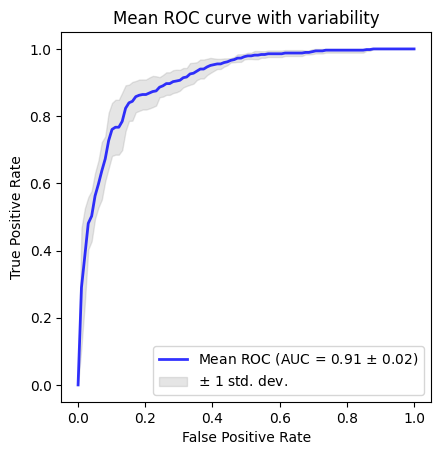

'\nplt.plot([0,1],[0,1],linestyle = \'--\',lw = 2,color = \'black\')\nmean_tpr = np.mean(tprs, axis=0)\nmean_auc = auc(mean_fpr, mean_tpr)\nplt.plot(mean_fpr, mean_tpr, color=\'blue\',\n         label=r\'Mean ROC (AUC = %0.2f )\' % (mean_auc),lw=2, alpha=1)\n\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'ROC\')\nplt.legend(loc="lower right")\n\nplt.show()\n'

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras import metrics
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold




Y=np.ones(949, dtype=np.float32)
Y[0:482]=0
Y[482:949]=1

X = data.iloc[:, 1:].values

XL = np.zeros((488,949))
for i in range(0,488):
  XL[i] = X[lossoD[i]]

#ROC CV
import matplotlib.pylab as plt
from scipy import interp
from sklearn.metrics import roc_curve,auc
tprsM = []
aucsM = []
mean_fprM = np.linspace(0, 1, 100)
fig, ax = plt.subplots()



X_Cross_Val_Data = np.transpose(XL)

# Merge inputs and targets
inputs = X_Cross_Val_Data
targets = Y

# Define the K-fold Cross Validator
#kfold = KFold(n_splits=5, shuffle=True)

kfold = KFold(n_splits=5, random_state=3, shuffle=True)



acc_per_fold = []
loss_per_fold = []
auc_per_fold = []
pre_per_fold = []
re_per_fold = []



# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  from sklearn.preprocessing import MinMaxScaler
  mmsc = MinMaxScaler()
  X_Cross_Val = mmsc.fit_transform(inputs[train])
  X_Cross_Val_Test = mmsc.transform(inputs[test]).clip(0,1)

  NumberOfLabels = 15
  q, mod = divmod(488, NumberOfLabels)
  LDALabels =np.ones(488, dtype=np.float32)

  for i in range(0,NumberOfLabels):
    LDALabels[0+(q*i):q*(i+1)]=i

  LDALabels[488-mod:488]=i

  it = ImageTransformer(feature_extractor='lda', pixels=90)

  X_Cross_Val_Image = it.fit_transform(X_Cross_Val, y = LDALabels)
  X_Cross_Val_Image_Test = it.transform(X_Cross_Val_Test)

#model merge
  model3 = models.Sequential()
  model3.add(BatchNormalization(input_shape=(90, 90, 3)))
  model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model3.add(layers.MaxPooling2D((2, 2)))
  model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model3.add(layers.MaxPooling2D((2, 2)))
  model3.add(BatchNormalization())
  model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model3.add(layers.MaxPooling2D((2, 2)))
  model3.add(GlobalAveragePooling2D())
  model3.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model3.add(Dropout(0.4))
  model3.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model3.add(Dropout(0.4))

  model4 = Sequential()
  model4.add(BatchNormalization(input_shape=(488,)))
  model4.add(Dense(128, activation='relu'))
  model4.add(Dense(64, activation='relu'))
  model4.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model4.add(Dropout(0.4))
  model4.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model4.add(Dropout(0.4))

  from keras.layers import concatenate, add, multiply
  mergedOutput = concatenate([model3.output, model4.output])

  out = Dense(32, activation='relu')(mergedOutput)
  out = Dropout(0.4)(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(1, activation='sigmoid')(out)

  new_model = Model(
      [model3.input, model4.input],
      out
  )



  # Compile the model
  new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])


#  checkpoint_filepath_modelmerged = '/content/drive/MyDrive/5FoldWeightesforROC/Merged_Weights_' + str(fold_no)
#  model_checkpoint_modelmerged = tf.keras.callbacks.ModelCheckpoint(
#      filepath=checkpoint_filepath_modelmerged,
#      save_weights_only=True,
#      monitor='loss',
##      monitor='val_accuracy',
##      mode='max',
#      mode='min',
#      save_best_only=True)

#  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode= 'min', start_from_epoch=250, patience=10, restore_best_weights=False)

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode= 'min', start_from_epoch=250, patience=10, restore_best_weights=True)







  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

    # Fit data to model
#  new_history = new_model.fit(x = [X_Cross_Val_Image, inputs[train]], y = targets[train], epochs=1000, batch_size=64, validation_data=([X_Cross_Val_Image_Test, inputs[test]], targets[test]), verbose=1, callbacks=[model_checkpoint_modelmerged])

  new_history = new_model.fit(x = [X_Cross_Val_Image, inputs[train]], y = targets[train], epochs=1003, batch_size=64, verbose=1, callbacks=[callback])

#  c_pathmerged = ('/content/drive/MyDrive/5FoldWeightesforROC/Merged_Weights_' + str(fold_no))
#  new_model.load_weights(c_pathmerged)

  # Generate generalization metrics
  scores = new_model.evaluate([X_Cross_Val_Image_Test, inputs[test]], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {new_model.metrics_names[0]} of {scores[0]}; {new_model.metrics_names[1]} of {scores[1]*100}%; AUC: {str(scores[2])}')
  acc_per_fold.append(scores[1])
  auc_per_fold.append(scores[2])
  pre_per_fold.append(scores[3])
  re_per_fold.append(scores[4])
  loss_per_fold.append(scores[0])


#model save
  filepath = ('Merged_Model_Weights_3_9' + str(fold_no))
  new_model.save_weights(filepath, overwrite=True, save_format=None, options=None)


#ROC curve
  """
  predictions = new_model.predict([X_Cross_Val_Image_Test, inputs[test]])
  fpr, tpr, thresholds = roc_curve(targets[test], predictions)
  tprs.append(interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (fold_no, roc_auc))
  """



  predictions = new_model.predict([X_Cross_Val_Image_Test, inputs[test]])
  fpr, tpr, thresholds = roc_curve(targets[test], predictions)
  roc_auc = auc(fpr, tpr)

  interp_tpr = np.interp(mean_fprM, fpr, tpr)
  interp_tpr[0] = 0.0
  tprsM.append(interp_tpr)
  aucsM.append(roc_auc)



  # Increase fold number
  fold_no = fold_no + 1


mean_tpr = np.mean(tprsM, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fprM, mean_tpr)
std_auc = np.std(aucsM)
ax.plot(
    mean_fprM,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprsM, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fprM,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


np.save('tprs_Merged.npy', np.array(tprsM, dtype=object), allow_pickle=True)
np.save('mean_fpr_Merged.npy', np.array(mean_fprM, dtype=object), allow_pickle=True)
np.save('aucs_Merged.npy', np.array(aucsM, dtype=object), allow_pickle=True)
#b = np.load('a.npy', allow_pickle=True)



"""
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()
"""


In [9]:
from statistics import mean

def F1_Score(a,b):
  f1score = 2*((a*b)/(a+b))
  return f1score


print(f'Merged Model      Acc: {mean(acc_per_fold)}     Auc: {mean(auc_per_fold)} Precision: {mean(pre_per_fold)}  Recall: {mean(re_per_fold)}  F1 Score:   {F1_Score(mean(pre_per_fold), mean(re_per_fold))}\n')

Merged Model      Acc: 0.8366416096687317     Auc: 0.8898759961128235 Precision: 0.8301526427268981  Recall: 0.8465189695358276  F1 Score:   0.838255928637387



**Feed Forward Model Results**

Epoch 1/1002
24/24 [==============================] - 4s 7ms/step - loss: 2.1978 - accuracy: 0.4954 - auc: 0.4652 - precision_16: 0.4987 - recall_16: 0.4948
Epoch 2/1002
24/24 [==============================] - 0s 7ms/step - loss: 1.2470 - accuracy: 0.4980 - auc: 0.4888 - precision_16: 0.5013 - recall_16: 0.5183
Epoch 3/1002
24/24 [==============================] - 0s 7ms/step - loss: 0.7987 - accuracy: 0.5257 - auc: 0.5321 - precision_16: 0.5272 - recall_16: 0.5576
Epoch 4/1002
24/24 [==============================] - 0s 7ms/step - loss: 0.7131 - accuracy: 0.5138 - auc: 0.5303 - precision_16: 0.5222 - recall_16: 0.4005
Epoch 5/1002
24/24 [==============================] - 0s 7ms/step - loss: 0.7193 - accuracy: 0.4954 - auc: 0.5008 - precision_16: 0.4974 - recall_16: 0.2487
Epoch 6/1002
24/24 [==============================] - 0s 6ms/step - loss: 0.7126 - accuracy: 0.5099 - auc: 0.5118 - precision_16: 0.5103 - recall_16: 0.6492
Epoch 7/1002
24/24 [==============================] - 0s 7

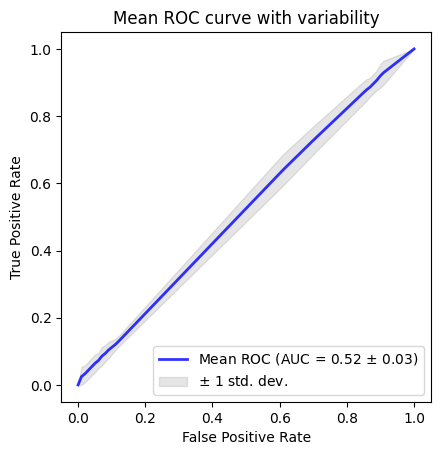

In [13]:
#Feed forward model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras import metrics
import numpy as np
from sklearn.linear_model import Lasso

Y=np.ones(949, dtype=np.float32)
Y[0:482]=0
Y[482:949]=1

'''
X = data.iloc[:, 1:].values

XL = np.zeros((488,949))
for i in range(0,488):
  XL[i] = X[lossoD[i]]
'''
#ROC CV
import matplotlib.pylab as plt
from scipy import interp
from sklearn.metrics import roc_curve,auc
tprsF = []
aucsF = []
mean_fprF = np.linspace(0, 1, 100)
fig, ax = plt.subplots()


X_Cross_Val_Data = np.transpose(X)

# Merge inputs and targets
inputs = X_Cross_Val_Data
targets = Y

# Define the K-fold Cross Validator
#kfold = KFold(n_splits=5, shuffle=True)

kfold = KFold(n_splits=5, random_state=3, shuffle=True)




acc_per_fold_model2 = []
loss_per_fold_model2 = []
auc_per_fold_model2 = []
pre_per_fold_model2 = []
re_per_fold_model2 = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  """
  from sklearn.preprocessing import MinMaxScaler
  mmsc = MinMaxScaler()
  X_Cross_Val = mmsc.fit_transform(inputs[train])
  X_Cross_Val_Test = mmsc.transform(inputs[test]).clip(0,1)

  NumberOfLabels = 15
  q, mod = divmod(1163, NumberOfLabels)
  LDALabels =np.ones(1163, dtype=np.float32)

  for i in range(0,NumberOfLabels):
    LDALabels[0+(q*i):q*(i+1)]=i

  LDALabels[1163-mod:1163]=i

  it = ImageTransformer(feature_extractor='lda', pixels=90)

  X_Cross_Val_Image = it.fit_transform(X_Cross_Val, y = LDALabels)
  X_Cross_Val_Image_Test = it.transform(X_Cross_Val_Test)
  """
#model 2

  model2 = Sequential()
  model2.add(BatchNormalization(input_shape=(11618,)))
  #model.add(Dense(256, activation='relu'))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dense(256, activation='relu'))
  model2.add(Dense(128, activation='relu'))
  #model.add(BatchNormalization())
  model2.add(Dense(64, activation='relu'))

  model2.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model2.add(Dropout(0.4))
  #model.add(Dense(32, activation='relu'))

  model2.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))

  model2.add(Dropout(0.4))
  model2.add(Dense(1, activation='sigmoid'))

  model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])



  callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss', mode= 'min', start_from_epoch=250, patience=10, restore_best_weights=True)

#  history_model2 = model2.fit(x = inputs[train], y = targets[train], epochs=1500, batch_size=32, validation_data=(inputs[test], targets[test]), verbose=1, callbacks=[model_checkpoint_model2])

  history_model2 = model2.fit(x = inputs[train], y = targets[train], epochs=1002, batch_size=32, verbose=1, callbacks=[callback2])

#  c_path2 = ('/content/drive/MyDrive/5FoldWeightes/Model2_Weights')
#  model2.load_weights(c_path2)

  # Generate generalization metrics
  scores_model2 = model2.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores_model2[0]}; {model2.metrics_names[1]} of {scores_model2[1]*100}%; AUC: {str(scores_model2[2])}')
  acc_per_fold_model2.append(scores_model2[1])
  auc_per_fold_model2.append(scores_model2[2])
  pre_per_fold_model2.append(scores_model2[3])
  re_per_fold_model2.append(scores_model2[4])
  loss_per_fold_model2.append(scores_model2[0])


#model save
  filepath = ('FNN_Model_Weights_3_9' + str(fold_no))
  new_model.save_weights(filepath, overwrite=True, save_format=None, options=None)



#ROC curve

  predictions = model2.predict(inputs[test])
  fpr, tpr, thresholds = roc_curve(targets[test], predictions)
  roc_auc = auc(fpr, tpr)

  interp_tpr = np.interp(mean_fprF, fpr, tpr)
  interp_tpr[0] = 0.0
  tprsF.append(interp_tpr)
  aucsF.append(roc_auc)




  # Increase fold number
  fold_no = fold_no + 1

mean_tpr = np.mean(tprsF, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fprF, mean_tpr)
std_auc = np.std(aucsF)
ax.plot(
    mean_fprF,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprsF, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fprF,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


np.save('tprs_FNN.npy', np.array(tprsF, dtype=object), allow_pickle=True)
np.save('mean_fpr_FNN.npy', np.array(mean_fprF, dtype=object), allow_pickle=True)
np.save('aucs_FNN.npy', np.array(aucsF, dtype=object), allow_pickle=True)
#b = np.load('a.npy', allow_pickle=True)

In [14]:
from statistics import mean

def F1_Score(a,b):
  f1score = 2*((a*b)/(a+b))
  return f1score


print(f'FeedForward Model Acc: {mean(acc_per_fold_model2)}     Auc: {mean(auc_per_fold_model2)}  Precision: {mean(pre_per_fold_model2)}  Recall: {mean(re_per_fold_model2)} F1 Score:   {F1_Score(mean(pre_per_fold_model2), mean(re_per_fold_model2))}\n')

FeedForward Model Acc: 0.5014981865882874     Auc: 0.5187282919883728  Precision: 0.19547151923179626  Recall: 0.29254902601242067 F1 Score:   0.2343548980537835



**CNN Model**

Epoch 1/1001
24/24 [==============================] - 5s 25ms/step - loss: 0.7460 - accuracy: 0.4888 - auc: 0.4733 - precision_22: 0.4928 - recall_22: 0.5340
Epoch 2/1001
24/24 [==============================] - 0s 20ms/step - loss: 0.7060 - accuracy: 0.5310 - auc: 0.5305 - precision_22: 0.5249 - recall_22: 0.7173
Epoch 3/1001
24/24 [==============================] - 0s 21ms/step - loss: 0.7080 - accuracy: 0.5336 - auc: 0.5299 - precision_22: 0.5302 - recall_22: 0.6440
Epoch 4/1001
24/24 [==============================] - 0s 20ms/step - loss: 0.7038 - accuracy: 0.5125 - auc: 0.5493 - precision_22: 0.5149 - recall_22: 0.5445
Epoch 5/1001
24/24 [==============================] - 0s 21ms/step - loss: 0.7030 - accuracy: 0.5296 - auc: 0.5517 - precision_22: 0.5254 - recall_22: 0.6780
Epoch 6/1001
24/24 [==============================] - 0s 20ms/step - loss: 0.7055 - accuracy: 0.4980 - auc: 0.5074 - precision_22: 0.5012 - recall_22: 0.5524
Epoch 7/1001
24/24 [==============================] 

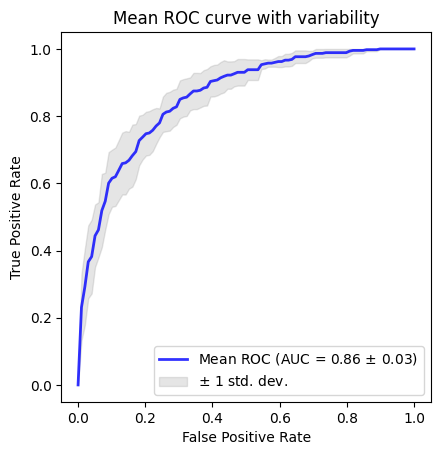

In [16]:
#CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from keras import metrics
import numpy as np
from sklearn.linear_model import Lasso

Y=np.ones(949, dtype=np.float32)
Y[0:482]=0
Y[482:949]=1

X = data.iloc[:, 1:].values

XL = np.zeros((488,949))
for i in range(0,488):
  XL[i] = X[lossoD[i]]

#ROC CV
import matplotlib.pylab as plt
from scipy import interp
from sklearn.metrics import roc_curve,auc
tprsC = []
aucsC = []
mean_fprC = np.linspace(0, 1, 100)
fig, ax = plt.subplots()


X_Cross_Val_Data = np.transpose(XL)

# Merge inputs and targets
inputs = X_Cross_Val_Data
targets = Y

# Define the K-fold Cross Validator
#kfold = KFold(n_splits=5, shuffle=True)

kfold = KFold(n_splits=5, random_state=3, shuffle=True)


acc_per_fold_model1 = []
loss_per_fold_model1 = []
auc_per_fold_model1 = []
pre_per_fold_model1 = []
re_per_fold_model1 = []


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  from sklearn.preprocessing import MinMaxScaler
  mmsc = MinMaxScaler()
  X_Cross_Val = mmsc.fit_transform(inputs[train])
  X_Cross_Val_Test = mmsc.transform(inputs[test]).clip(0,1)

  NumberOfLabels = 15
  q, mod = divmod(488, NumberOfLabels)
  LDALabels =np.ones(488, dtype=np.float32)

  for i in range(0,NumberOfLabels):
    LDALabels[0+(q*i):q*(i+1)]=i

  LDALabels[488-mod:488]=i

  it = ImageTransformer(feature_extractor='lda', pixels=90)

  X_Cross_Val_Image = it.fit_transform(X_Cross_Val, y = LDALabels)
  X_Cross_Val_Image_Test = it.transform(X_Cross_Val_Test)

#model merge
  model1 = models.Sequential()
  model1.add(BatchNormalization(input_shape=(90, 90, 3)))
  model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model1.add(layers.MaxPooling2D((2, 2)))
  model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model1.add(layers.MaxPooling2D((2, 2)))
  model1.add(BatchNormalization())
  model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model1.add(layers.MaxPooling2D((2, 2)))
  #model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  #model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  #model.add(layers.MaxPooling2D((2, 2)))

  model1.add(GlobalAveragePooling2D())
  #model.add(layers.Flatten())

  model1.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model1.add(Dropout(0.4))
  model1.add(layers.Dense(32, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4),
      activity_regularizer=regularizers.l2(1e-5)))
  model1.add(Dropout(0.4))

  #önceki modelde dense 64 ve 32 node.


  #model.add(layers.Dense(3, activation='softmax'))
  model1.add(layers.Dense(1, activation='sigmoid'))


  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


  model1.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics= ['accuracy', 'AUC', tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])

  #              loss=tf.keras.losses.CategoricalCrossentropy(),
  #              metrics= [tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision, tf.keras.metrics.Recall])





# training early stop
  callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', mode= 'min', start_from_epoch=250, patience=10, restore_best_weights=True)

#model to save best val_accuracy weights
#  history_model1 = model1.fit(x = X_Cross_Val_Image, y = targets[train], epochs=1500, batch_size=32, validation_data=(X_Cross_Val_Image_Test, targets[test]), verbose=1, callbacks=[model_checkpoint_model1])



#model to stop training with callback
  history_model1 = model1.fit(x = X_Cross_Val_Image, y = targets[train], epochs=1001, batch_size=32, verbose=1, callbacks=[callback1])


# model reload
#  c_path1 = ('/content/drive/MyDrive/5FoldWeightes/Model1_Weights')
#  model1.load_weights(c_path1)

  # Generate generalization metrics
  scores_model1 = model1.evaluate(X_Cross_Val_Image_Test, targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores_model1[0]}; {model1.metrics_names[1]} of {scores_model1[1]*100}%; AUC: {str(scores_model1[2])}')
  acc_per_fold_model1.append(scores_model1[1] * 100)
  auc_per_fold_model1.append(scores_model1[2] * 100)
  pre_per_fold_model1.append(scores_model1[3])
  re_per_fold_model1.append(scores_model1[4])
  loss_per_fold_model1.append(scores_model1[0])


#model save
  filepath = ('CNN_Model_Weights_3_9' + str(fold_no))
  new_model.save_weights(filepath, overwrite=True, save_format=None, options=None)



#ROC curve

  predictions = model1.predict([X_Cross_Val_Image_Test])
  fpr, tpr, thresholds = roc_curve(targets[test], predictions)
  roc_auc = auc(fpr, tpr)

  interp_tpr = np.interp(mean_fprC, fpr, tpr)
  interp_tpr[0] = 0.0
  tprsC.append(interp_tpr)
  aucsC.append(roc_auc)


  # Increase fold number
  fold_no = fold_no + 1

mean_tpr = np.mean(tprsC, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fprC, mean_tpr)
std_auc = np.std(aucsC)
ax.plot(
    mean_fprC,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprsC, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fprC,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()


np.save('tprs_CNN.npy', np.array(tprsC, dtype=object), allow_pickle=True)
np.save('mean_fpr_CNN.npy', np.array(mean_fprC, dtype=object), allow_pickle=True)
np.save('aucs_CNN.npy', np.array(aucsC, dtype=object), allow_pickle=True)
#b = np.load('a.npy', allow_pickle=True)





In [17]:
from statistics import mean

def F1_Score(a,b):
  f1score = 2*((a*b)/(a+b))
  return f1score

print(f'CNN Model         Acc: {mean(acc_per_fold_model1)}     Auc: {mean(auc_per_fold_model1)}  Precision: {mean(pre_per_fold_model1)}  Recall: {mean(re_per_fold_model1)} F1 Score:   {F1_Score(mean(pre_per_fold_model1), mean(re_per_fold_model1))}\n')

CNN Model         Acc: 76.91785097122192     Auc: 81.56044006347656  Precision: 0.7980163335800171  Recall: 0.7149220705032349 F1 Score:   0.7541873323575601



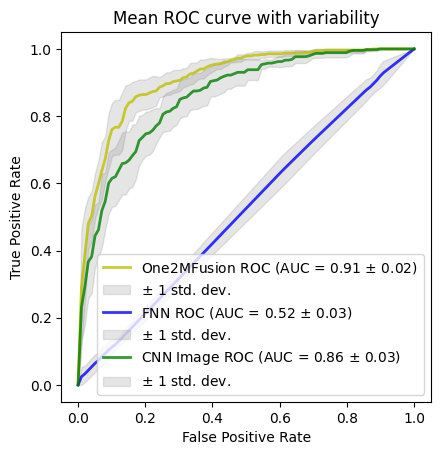

<Figure size 4500x4500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [40]:
fig, ax = plt.subplots()
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=300)


#Merged Model Roc Curve
mean_tpr = np.mean(tprsM, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fprM, mean_tpr)
std_auc = np.std(aucsM)
ax.plot(
    mean_fprM,
    mean_tpr,
    color="y",
    label=r"One2MFusion ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprsM, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fprM,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)

#FNN Roc Curve

mean_tpr = np.mean(tprsF, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fprF, mean_tpr)
std_auc = np.std(aucsF)
ax.plot(
    mean_fprF,
    mean_tpr,
    color="b",
    label=r"FNN ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprsF, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fprF,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)



#CNN Roc Curve

mean_tpr = np.mean(tprsC, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fprC, mean_tpr)
std_auc = np.std(aucsC)
ax.plot(
    mean_fprC,
    mean_tpr,
    color="g",
    label=r"CNN Image ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprsC, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fprC,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)

ax.axis("square")
ax.legend(loc="lower right")
plt.show()


plt.savefig('RocCurve1.png')



In [36]:
plt.savefig('RocCurve.png')

<Figure size 640x480 with 0 Axes>

In [41]:
tprsM

[array([0.        , 0.48235294, 0.55294118, 0.58823529, 0.58823529,
        0.67058824, 0.69411765, 0.71764706, 0.71764706, 0.8       ,
        0.81176471, 0.81176471, 0.81176471, 0.82352941, 0.87058824,
        0.88235294, 0.88235294, 0.90588235, 0.91764706, 0.91764706,
        0.91764706, 0.92941176, 0.92941176, 0.92941176, 0.92941176,
        0.94117647, 0.94117647, 0.94117647, 0.94117647, 0.94117647,
        0.94117647, 0.94117647, 0.94117647, 0.96470588, 0.96470588,
        0.96470588, 0.96470588, 0.96470588, 0.96470588, 0.97647059,
        0.97647059, 0.97647059, 0.97647059, 0.97647059, 0.97647059,
        0.97647059, 0.97647059, 0.97647059, 0.97647059, 0.97647059,
        0.98823529, 0.98823529, 0.98823529, 0.98823529, 0.98823529,
        0.98823529, 0.98823529, 0.98823529, 0.98823529, 0.98823529,
        0.98823529, 0.98823529, 0.98823529, 0.98823529, 0.98823529,
        0.98823529, 0.98823529, 0.98823529, 0.98823529, 0.98823529,
        1.        , 1.        , 1.        , 1.  

In [42]:
mean_fprM

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [43]:
aucsM

[0.9330532212885153,
 0.9066666666666667,
 0.9217777777777778,
 0.9029486753131581,
 0.8799885321100918]

In [44]:
tprsF

[array([0.        , 0.08235294, 0.08235294, 0.09411765, 0.10588235,
        0.11764706, 0.11764706, 0.14117647, 0.14117647, 0.15294118,
        0.15294118, 0.15294118, 0.1610037 , 0.17276155, 0.1845194 ,
        0.19627725, 0.2080351 , 0.21979295, 0.2315508 , 0.24330865,
        0.2550665 , 0.26682435, 0.2785822 , 0.29034005, 0.3020979 ,
        0.31385575, 0.3256136 , 0.33737145, 0.3491293 , 0.36088715,
        0.372645  , 0.38440285, 0.3961607 , 0.40791855, 0.4196764 ,
        0.43143425, 0.4431921 , 0.45494995, 0.4667078 , 0.47846565,
        0.4902235 , 0.50198135, 0.5137392 , 0.52549705, 0.5372549 ,
        0.54901275, 0.5607706 , 0.57252845, 0.5842863 , 0.59604415,
        0.607802  , 0.61955985, 0.6313177 , 0.64307555, 0.6548334 ,
        0.66659125, 0.6783491 , 0.69010695, 0.7018648 , 0.71362265,
        0.7253805 , 0.73508844, 0.74372686, 0.75236528, 0.7610037 ,
        0.76964212, 0.77828054, 0.78691896, 0.79555738, 0.8041958 ,
        0.81283422, 0.82147265, 0.83011107, 0.83

In [45]:
mean_fprF

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [46]:
aucsF

[0.579719887955182, 0.5166666666666667, 0.5, 0.5, 0.5]

In [47]:
tprsC

[array([0.        , 0.42352941, 0.50588235, 0.56470588, 0.57647059,
        0.6       , 0.6       , 0.6       , 0.61176471, 0.70588235,
        0.70588235, 0.71764706, 0.71764706, 0.72941176, 0.72941176,
        0.72941176, 0.77647059, 0.78823529, 0.84705882, 0.84705882,
        0.84705882, 0.84705882, 0.85882353, 0.85882353, 0.85882353,
        0.90588235, 0.91764706, 0.91764706, 0.91764706, 0.91764706,
        0.92941176, 0.92941176, 0.92941176, 0.92941176, 0.95294118,
        0.95294118, 0.95294118, 0.95294118, 0.95294118, 0.95294118,
        0.95294118, 0.95294118, 0.95294118, 0.95294118, 0.95294118,
        0.95294118, 0.95294118, 0.95294118, 0.95294118, 0.95294118,
        0.95294118, 0.95294118, 0.95294118, 0.95294118, 0.95294118,
        0.96470588, 0.96470588, 0.96470588, 0.97647059, 0.98823529,
        0.98823529, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.  

In [48]:
mean_fprC

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [49]:
aucsC

[0.9057142857142857,
 0.8436666666666668,
 0.8747777777777778,
 0.8507925950559805,
 0.8144495412844037]